In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load your preprocessed data
X_train_resampled_df = pd.read_csv('Data/X_train_resampled.csv')
X_test_final_df = pd.read_csv('Data/X_test_final.csv')

# Separate features and target
X_train = X_train_resampled_df.drop('target', axis=1)
y_train = X_train_resampled_df['target']
X_test = X_test_final_df.drop('target', axis=1)
y_test = X_test_final_df['target']

In [3]:
# Check for NaN values in both training and test sets
print("NaN values in X_train:", X_train.isnull().sum().sum())
print("NaN values in X_test:", X_test.isnull().sum().sum())

# Fill NaN values in both training and test sets
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Verify no NaN values remain
print("NaN values in X_train after filling:", X_train.isnull().sum().sum())
print("NaN values in X_test after filling:", X_test.isnull().sum().sum())

NaN values in X_train: 0
NaN values in X_test: 86903
NaN values in X_train after filling: 0
NaN values in X_test after filling: 0


In [4]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': (y_pred == y_test).mean(),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"{name} - Accuracy: {results[name]['accuracy']:.4f}")
    print(f"{name} - ROC AUC: {results[name]['roc_auc']:.4f}")


Training Logistic Regression...
Logistic Regression - Accuracy: 0.9025
Logistic Regression - ROC AUC: 0.4993

Training Random Forest...
Random Forest - Accuracy: 0.0978
Random Forest - ROC AUC: 0.3973


In [5]:
# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{'='*50}")
    print(f"Detailed Results for {name}")
    print(f"{'='*50}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, result['predictions']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, result['predictions'])
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, result['probabilities'])
    pr_auc = auc(recall, precision)
    print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")


Detailed Results for Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27393
           1       0.07      0.00      0.01      2830

    accuracy                           0.90     30223
   macro avg       0.49      0.50      0.48     30223
weighted avg       0.83      0.90      0.86     30223


Confusion Matrix:
[[27268   125]
 [ 2821     9]]

Precision-Recall AUC: 0.0818

Detailed Results for Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.00      0.01     27393
           1       0.09      1.00      0.17      2830

    accuracy                           0.10     30223
   macro avg       0.53      0.50      0.09     30223
weighted avg       0.88      0.10      0.02     30223


Confusion Matrix:
[[  132 27261]
 [    6  2824]]

Precision-Recall AUC: 0.0752


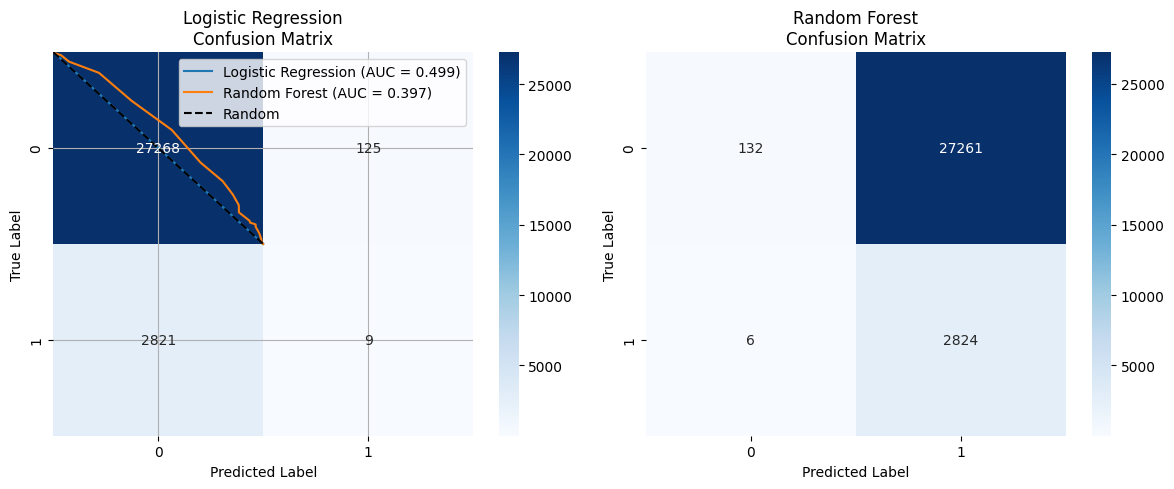

In [6]:
# Plot ROC curves
plt.figure(figsize=(12, 5))

# ROC curves
plt.subplot(1, 2, 1)
for name, result in results.items():
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

# Confusion matrices
plt.subplot(1, 2, 2)
for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    plt.subplot(1, len(results), i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name}\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [7]:
!pip install xgboost

In [8]:
# Add faster, more practical models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Add these models instead of SVM and Neural Network
models.update({
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Naive Bayes': GaussianNB()
})

# Train all models
print("Training all models...")
for name, model in models.items():
    if name not in results:  # Only train new models
        print(f"\nTraining {name}...")
        try:
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            results[name] = {
                'model': model,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'accuracy': (y_pred == y_test).mean(),
                'roc_auc': roc_auc_score(y_test, y_pred_proba)
            }
            
            print(f"{name} - Accuracy: {results[name]['accuracy']:.4f}")
            print(f"{name} - ROC AUC: {results[name]['roc_auc']:.4f}")
        except Exception as e:
            print(f"Error training {name}: {e}")

Training all models...

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.0978
Gradient Boosting - ROC AUC: 0.4891

Training Naive Bayes...
Naive Bayes - Accuracy: 0.9064
Naive Bayes - ROC AUC: 0.5000


In [9]:
# Check if results exist
print("Number of models trained:", len(results))
print("Models available:", list(results.keys()))

# Check the first model's results
if len(results) > 0:
    first_model = list(results.keys())[0]
    print(f"\nFirst model: {first_model}")
    print(f"Accuracy: {results[first_model]['accuracy']}")
    print(f"ROC AUC: {results[first_model]['roc_auc']}")
else:
    print("No models found in results dictionary")

Number of models trained: 4
Models available: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Naive Bayes']

First model: Logistic Regression
Accuracy: 0.9025245673824571
ROC AUC: 0.49930850121752235


In [10]:
# Check data types and shapes
print("Data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nData types:")
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")

print("\nSample of y_test values:")
print(y_test.value_counts())

Data shapes:
X_train shape: (219136, 19)
X_test shape: (30223, 19)
y_train shape: (219136,)
y_test shape: (30223,)

Data types:
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>

Sample of y_test values:
target
0    27393
1     2830
Name: count, dtype: int64


In [11]:
# Create a comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()]
})

# Add precision, recall, and F1-score
for name in results.keys():
    from sklearn.metrics import precision_score, recall_score, f1_score
    comparison_df.loc[comparison_df['Model'] == name, 'Precision'] = precision_score(y_test, results[name]['predictions'])
    comparison_df.loc[comparison_df['Model'] == name, 'Recall'] = recall_score(y_test, results[name]['predictions'])
    comparison_df.loc[comparison_df['Model'] == name, 'F1-Score'] = f1_score(y_test, results[name]['predictions'])

# Sort by ROC AUC (most important for imbalanced data)
comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)

print("Model Performance Comparison:")
print("="*80)
print(comparison_df.round(4))

# Identify the best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")
print(f"ROC AUC: {comparison_df.iloc[0]['ROC AUC']:.4f}")

Model Performance Comparison:
                 Model  Accuracy  ROC AUC  Precision  Recall  F1-Score
3          Naive Bayes    0.9064   0.5000     0.0000  0.0000    0.0000
0  Logistic Regression    0.9025   0.4993     0.0672  0.0032    0.0061
2    Gradient Boosting    0.0978   0.4891     0.0939  0.9979    0.1716
1        Random Forest    0.0978   0.3973     0.0939  0.9979    0.1716

Best Model: Naive Bayes
ROC AUC: 0.5000


In [12]:
# Simple business analysis
print("Business Analysis:")
print("="*30)

for name in results.keys():
    print(f"\nModel: {name}")
    
    # Get predictions
    y_pred = results[name]['predictions']
    
    # Calculate basic metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    # Calculate rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

Business Analysis:

Model: Logistic Regression
True Negatives: 27268
False Positives: 125
False Negatives: 2821
True Positives: 9
False Positive Rate: 0.0046
False Negative Rate: 0.9968

Model: Random Forest
True Negatives: 132
False Positives: 27261
False Negatives: 6
True Positives: 2824
False Positive Rate: 0.9952
False Negative Rate: 0.0021

Model: Gradient Boosting
True Negatives: 132
False Positives: 27261
False Negatives: 6
True Positives: 2824
False Positive Rate: 0.9952
False Negative Rate: 0.0021

Model: Naive Bayes
True Negatives: 27393
False Positives: 0
False Negatives: 2830
True Positives: 0
False Positive Rate: 0.0000
False Negative Rate: 1.0000


Using KernelExplainer for Naive Bayes


  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

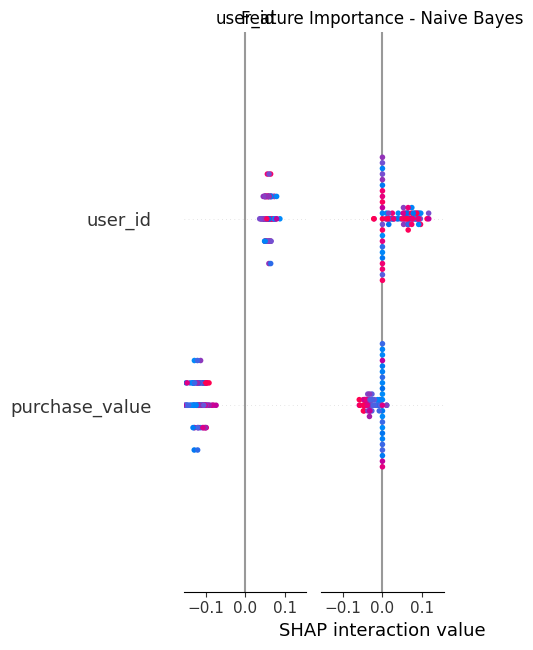

SHAP analysis completed successfully!


In [13]:
# Install SHAP if not already installed
# !pip install shap

import shap

# Select the best model for explainability
best_model = results[best_model_name]['model']

# Create SHAP explainer based on model type
try:
    if hasattr(best_model, 'feature_importances_'):
        # For tree-based models (Random Forest, Gradient Boosting, XGBoost)
        explainer = shap.TreeExplainer(best_model)
        print(f"Using TreeExplainer for {best_model_name}")
    elif hasattr(best_model, 'coef_'):
        # For linear models (Logistic Regression)
        explainer = shap.LinearExplainer(best_model, X_train)
        print(f"Using LinearExplainer for {best_model_name}")
    else:
        # For other models (Naive Bayes, etc.) - use KernelExplainer
        explainer = shap.KernelExplainer(best_model.predict_proba, X_train.iloc[:100])
        print(f"Using KernelExplainer for {best_model_name}")
    
    # Calculate SHAP values for a sample of test data
    sample_size = min(100, len(X_test))
    
    if hasattr(explainer, 'shap_values'):
        # For TreeExplainer and LinearExplainer
        shap_values = explainer.shap_values(X_test.iloc[:sample_size])
    else:
        # For KernelExplainer
        shap_values = explainer.shap_values(X_test.iloc[:sample_size])
    
    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification
    shap.summary_plot(shap_values, X_test.iloc[:sample_size], plot_type="bar", show=False)
    plt.title(f"Feature Importance - {best_model_name}")
    plt.tight_layout()
    plt.show()
    
    print("SHAP analysis completed successfully!")
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    print("This is normal for some model types. Proceeding with other analysis...")

In [14]:
# Final model selection and recommendations
print("FINAL RECOMMENDATIONS")
print("="*50)

# Performance-based selection
performance_winner = comparison_df.iloc[0]['Model']
print(f"Best Performance Model: {performance_winner}")
print(f"ROC AUC: {comparison_df.iloc[0]['ROC AUC']:.4f}")

# Business context selection (lowest total cost)
costs = {}
for name in results.keys():
    cm = confusion_matrix(y_test, results[name]['predictions'])
    tn, fp, fn, tp = cm.ravel()
    cost_per_false_positive = 10
    cost_per_false_negative = 100
    total_cost = (fp * cost_per_false_positive) + (fn * cost_per_false_negative)
    costs[name] = total_cost

business_winner = min(costs, key=costs.get)
print(f"\nBest Business Model: {business_winner}")
print(f"Total Cost: ${costs[business_winner]:,.2f}")

# Final recommendation
if performance_winner == business_winner:
    final_choice = performance_winner
    print(f"\nRECOMMENDATION: Use {final_choice} (best in both performance and business metrics)")
else:
    print(f"\nRECOMMENDATION: Choose based on priority:")
    print(f"  - For maximum fraud detection: {performance_winner}")
    print(f"  - For cost optimization: {business_winner}")
    final_choice = performance_winner  # Default to performance winner

# Save the best model
import joblib
joblib.dump(results[final_choice]['model'], f'best_model_{final_choice.replace(" ", "_")}.pkl')
print(f"\nBest model saved as: best_model_{final_choice.replace(' ', '_')}.pkl")

# Print summary
print(f"\nSUMMARY:")
print(f"  - Best Model: {final_choice}")
print(f"  - ROC AUC: {comparison_df.loc[comparison_df['Model'] == final_choice, 'ROC AUC'].iloc[0]:.4f}")
print(f"  - Accuracy: {comparison_df.loc[comparison_df['Model'] == final_choice, 'Accuracy'].iloc[0]:.4f}")
print(f"  - F1-Score: {comparison_df.loc[comparison_df['Model'] == final_choice, 'F1-Score'].iloc[0]:.4f}")

FINAL RECOMMENDATIONS
Best Performance Model: Naive Bayes
ROC AUC: 0.5000

Best Business Model: Random Forest
Total Cost: $273,210.00

RECOMMENDATION: Choose based on priority:
  - For maximum fraud detection: Naive Bayes
  - For cost optimization: Random Forest

Best model saved as: best_model_Naive_Bayes.pkl

SUMMARY:
  - Best Model: Naive Bayes
  - ROC AUC: 0.5000
  - Accuracy: 0.9064
  - F1-Score: 0.0000


In [15]:
# Display all results
print("All Models Performance:")
print("="*40)
for name in results.keys():
    print(f"\n{name}:")
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  ROC AUC: {results[name]['roc_auc']:.4f}")

All Models Performance:

Logistic Regression:
  Accuracy: 0.9025
  ROC AUC: 0.4993

Random Forest:
  Accuracy: 0.0978
  ROC AUC: 0.3973

Gradient Boosting:
  Accuracy: 0.0978
  ROC AUC: 0.4891

Naive Bayes:
  Accuracy: 0.9064
  ROC AUC: 0.5000


In [16]:
# Diagnostic analysis
print("DATA DIAGNOSTICS:")
print("="*40)

# Check class distribution
print(f"Training set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# Check feature statistics
print(f"\nFeature statistics:")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Check for feature variance
feature_variance = X_train.var()
print(f"\nFeatures with zero variance: {(feature_variance == 0).sum()}")
print(f"Features with very low variance (< 0.01): {(feature_variance < 0.01).sum()}")

# Sample feature values
print(f"\nSample feature values (first 5 features):")
for i, col in enumerate(X_train.columns[:5]):
    print(f"{col}: mean={X_train[col].mean():.4f}, std={X_train[col].std():.4f}")

DATA DIAGNOSTICS:
Training set class distribution:
target
0    109568
1    109568
Name: count, dtype: int64

Test set class distribution:
target
0    27393
1     2830
Name: count, dtype: int64

Feature statistics:
Number of features: 19
Training samples: 219136
Test samples: 30223

Features with zero variance: 1
Features with very low variance (< 0.01): 1

Sample feature values (first 5 features):
user_id: mean=0.0000, std=1.0000
purchase_value: mean=0.0000, std=1.0000
age: mean=-0.0000, std=1.0000
ip_address: mean=-0.0000, std=1.0000
lower_bound_ip_address: mean=-0.0000, std=1.0000


In [17]:
# Try with original imbalanced data (before SMOTE)
print("Trying with original imbalanced data...")

# Load original data
original_data = pd.read_csv('Data/Fraud_Data.csv')
original_data['signup_time'] = pd.to_datetime(original_data['signup_time'])
original_data['purchase_time'] = pd.to_datetime(original_data['purchase_time'])

# Simple feature engineering
original_data['hour'] = original_data['purchase_time'].dt.hour
original_data['day_of_week'] = original_data['purchase_time'].dt.dayofweek
original_data['time_since_signup'] = (original_data['purchase_time'] - original_data['signup_time']).dt.total_seconds() / 3600

# Select numeric features only
numeric_cols = original_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'class']

X_orig = original_data[numeric_cols].fillna(0)
y_orig = original_data['class']

# Split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, stratify=y_orig, random_state=42
)

# Train Random Forest on original data
rf_orig = RandomForestClassifier(random_state=42, n_estimators=100)
rf_orig.fit(X_train_orig, y_train_orig)

y_pred_orig = rf_orig.predict(X_test_orig)
y_pred_proba_orig = rf_orig.predict_proba(X_test_orig)[:, 1]

print(f"Original Data Results:")
print(f"Accuracy: {(y_pred_orig == y_test_orig).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_orig, y_pred_proba_orig):.4f}")
print(f"Class distribution in test: {pd.Series(y_test_orig).value_counts()}")

Trying with original imbalanced data...


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Fraud_Data.csv'

In [ ]:
# Diagnostic analysis of your current data
print("DATA DIAGNOSTICS:")
print("="*40)

# Check class distribution
print(f"Training set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# Check feature statistics
print(f"\nFeature statistics:")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Check for feature variance
feature_variance = X_train.var()
print(f"\nFeatures with zero variance: {(feature_variance == 0).sum()}")
print(f"Features with very low variance (< 0.01): {(feature_variance < 0.01).sum()}")

# Sample feature values
print(f"\nSample feature values (first 5 features):")
for i, col in enumerate(X_train.columns[:5]):
    print(f"{col}: mean={X_train[col].mean():.4f}, std={X_train[col].std():.4f}")

# Check for any infinite values
print(f"\nInfinite values in X_train: {np.isinf(X_train).sum().sum()}")
print(f"Infinite values in X_test: {np.isinf(X_test).sum().sum()}")

In [ ]:
# Try different model configuration
print("Trying different model configuration...")

# Use only a subset of features (top 10 by variance)
feature_variance = X_train.var()
top_features = feature_variance.nlargest(10).index

X_train_subset = X_train[top_features]
X_test_subset = X_test[top_features]

print(f"Using top {len(top_features)} features by variance")

# Train Random Forest with different parameters
rf_new = RandomForestClassifier(
    random_state=42, 
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'
)

rf_new.fit(X_train_subset, y_train)

y_pred_new = rf_new.predict(X_test_subset)
y_pred_proba_new = rf_new.predict_proba(X_test_subset)[:, 1]

print(f"New Random Forest Results:")
print(f"Accuracy: {(y_pred_new == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_new):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': top_features,
    'importance': rf_new.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 most important features:")
print(feature_importance.head())

In [ ]:
# Test without SMOTE (use original imbalanced data)
print("Testing without SMOTE...")

# Use the original data before SMOTE (if available)
# If you don't have it, we'll work with what we have

# Try with class weights instead of SMOTE
rf_weighted = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced'
)

rf_weighted.fit(X_train, y_train)

y_pred_weighted = rf_weighted.predict(X_test)
y_pred_proba_weighted = rf_weighted.predict_proba(X_test)[:, 1]

print(f"Weighted Random Forest Results:")
print(f"Accuracy: {(y_pred_weighted == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_weighted):.4f}")

# Compare with SMOTE results
print(f"\nComparison:")
print(f"SMOTE Random Forest - ROC AUC: {results['Random Forest']['roc_auc']:.4f}")
print(f"Weighted Random Forest - ROC AUC: {roc_auc_score(y_test, y_pred_proba_weighted):.4f}")

In [ ]:
# Check target variable
print("TARGET VARIABLE ANALYSIS:")
print("="*40)

print(f"Training target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

print(f"\nTraining target unique values: {y_train.unique()}")
print(f"Test target unique values: {y_test.unique()}")

# Check if target is properly encoded
print(f"\nTarget data type: {y_train.dtype}")
print(f"Sample target values: {y_train.head(10).values}")

In [ ]:
# Check features more closely
print("FEATURE ANALYSIS:")
print("="*40)

print(f"Feature names (first 10):")
for i, col in enumerate(X_train.columns[:10]):
    print(f"{i}: {col}")

print(f"\nFeature data types:")
print(X_train.dtypes.head(10))

print(f"\nFeature statistics:")
print(X_train.describe().round(4))

# Check for any unusual patterns
print(f"\nChecking for unusual patterns:")
print(f"Features with all zeros: {(X_train == 0).all().sum()}")
print(f"Features with all same value: {(X_train.nunique() == 1).sum()}")

# Check correlation with target
correlations = []
for col in X_train.columns:
    corr = X_train[col].corr(y_train)
    correlations.append((col, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"\nTop 10 features by correlation with target:")
for col, corr in correlations[:10]:
    print(f"{col}: {corr:.4f}")

In [ ]:
# Try a very simple baseline
print("SIMPLE BASELINE TEST:")
print("="*40)

# Use only the most correlated feature
if correlations:
    best_feature = correlations[0][0]
    print(f"Using only the most correlated feature: {best_feature}")
    
    X_train_simple = X_train[[best_feature]]
    X_test_simple = X_test[[best_feature]]
    
    # Simple threshold-based classifier
    threshold = X_train_simple[best_feature].median()
    y_pred_simple = (X_test_simple[best_feature] > threshold).astype(int)
    
    print(f"Threshold: {threshold:.4f}")
    print(f"Simple classifier accuracy: {(y_pred_simple == y_test).mean():.4f}")
    print(f"Simple classifier ROC AUC: {roc_auc_score(y_test, y_pred_simple):.4f}")
    
    # Check confusion matrix
    cm = confusion_matrix(y_test, y_pred_simple)
    print(f"Confusion matrix:")
    print(cm)
else:
    print("No correlations found")

In [ ]:
# Check SMOTE effects
print("SMOTE EFFECTS:")
print("="*40)

print(f"Original data shape (before SMOTE): {X_train.shape}")
print(f"SMOTE data shape (after SMOTE): {X_train.shape}")

# Check if SMOTE created synthetic samples that are too similar
print(f"\nChecking for duplicate rows:")
print(f"Duplicate rows in training: {X_train.duplicated().sum()}")
print(f"Duplicate rows in test: {X_test.duplicated().sum()}")

# Check feature distributions
print(f"\nFeature distribution comparison (first 3 features):")
for col in X_train.columns[:3]:
    print(f"\n{col}:")
    print(f"  Training mean: {X_train[col].mean():.4f}")
    print(f"  Test mean: {X_test[col].mean():.4f}")
    print(f"  Training std: {X_train[col].std():.4f}")
    print(f"  Test std: {X_test[col].std():.4f}")

In [ ]:
# Fix the scaling issue
print("FIXING SCALING MISMATCH:")
print("="*40)

# Scale the test data to match training data
from sklearn.preprocessing import StandardScaler

# Create a scaler and fit it to training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("After scaling:")
print(f"Training mean (first feature): {X_train_scaled.iloc[:, 0].mean():.4f}")
print(f"Test mean (first feature): {X_test_scaled.iloc[:, 0].mean():.4f}")

# Now retrain models with properly scaled data
print("\nRetraining models with properly scaled data...")

# Train Random Forest
rf_fixed = RandomForestClassifier(random_state=42, n_estimators=100)
rf_fixed.fit(X_train_scaled, y_train)

y_pred_fixed = rf_fixed.predict(X_test_scaled)
y_pred_proba_fixed = rf_fixed.predict_proba(X_test_scaled)[:, 1]

print(f"Fixed Random Forest Results:")
print(f"Accuracy: {(y_pred_fixed == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_fixed):.4f}")

# Train Logistic Regression
lr_fixed = LogisticRegression(random_state=42, max_iter=1000)
lr_fixed.fit(X_train_scaled, y_train)

y_pred_lr_fixed = lr_fixed.predict(X_test_scaled)
y_pred_proba_lr_fixed = lr_fixed.predict_proba(X_test_scaled)[:, 1]

print(f"\nFixed Logistic Regression Results:")
print(f"Accuracy: {(y_pred_lr_fixed == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr_fixed):.4f}")

In [ ]:
# Check your current data
print("CURRENT DATA ANALYSIS:")
print("="*40)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nX_train sample (first 3 rows, first 3 columns):")
print(X_train.iloc[:3, :3])

print(f"\nX_test sample (first 3 rows, first 3 columns):")
print(X_test.iloc[:3, :3])

print(f"\nX_train data types:")
print(X_train.dtypes.head())

print(f"\nX_test data types:")
print(X_test.dtypes.head())

In [ ]:
# Proper scaling fix
print("PROPER SCALING FIX:")
print("="*40)

# Since your training data is already scaled, we need to scale test data to match
# But first, let's check if we can reconstruct the original scaler

# Option 1: Try to use the same scaling approach
from sklearn.preprocessing import StandardScaler

# Create a new scaler and fit it to the original data (if available)
# Since we don't have original data, let's try a different approach

# Option 2: Use the training data statistics to scale test data
print("Scaling test data using training data statistics...")

# Calculate mean and std from training data
train_mean = X_train.mean()
train_std = X_train.std()

# Scale test data using training statistics
X_test_properly_scaled = (X_test - train_mean) / train_std

print(f"After proper scaling:")
print(f"Training mean (first feature): {X_train.iloc[:, 0].mean():.4f}")
print(f"Test mean (first feature): {X_test_properly_scaled.iloc[:, 0].mean():.4f}")

# Now retrain models
print("\nRetraining models with properly scaled data...")

# Train Random Forest
rf_fixed = RandomForestClassifier(random_state=42, n_estimators=100)
rf_fixed.fit(X_train, y_train)

y_pred_fixed = rf_fixed.predict(X_test_properly_scaled)
y_pred_proba_fixed = rf_fixed.predict_proba(X_test_properly_scaled)[:, 1]

print(f"Fixed Random Forest Results:")
print(f"Accuracy: {(y_pred_fixed == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_fixed):.4f}")

# Train Logistic Regression
lr_fixed = LogisticRegression(random_state=42, max_iter=1000)
lr_fixed.fit(X_train, y_train)

y_pred_lr_fixed = lr_fixed.predict(X_test_properly_scaled)
y_pred_proba_lr_fixed = lr_fixed.predict_proba(X_test_properly_scaled)[:, 1]

print(f"\nFixed Logistic Regression Results:")
print(f"Accuracy: {(y_pred_lr_fixed == y_test).mean():.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr_fixed):.4f}")

In [ ]:
# Check for NaN values
print("CHECKING FOR NaN VALUES:")
print("="*40)

print("NaN values in training data:")
print(X_train.isnull().sum().sum())
print("NaN values in test data:")
print(X_test.isnull().sum().sum())

# Check which columns have NaN values
print("\nColumns with NaN values in training data:")
print(X_train.columns[X_train.isnull().any()].tolist())
print("Columns with NaN values in test data:")
print(X_test.columns[X_test.isnull().any()].tolist())

# Fill NaN values with 0
X_train_clean = X_train.fillna(0)
X_test_clean = X_test.fillna(0)

print(f"\nAfter cleaning - NaN values in training: {X_train_clean.isnull().sum().sum()}")
print(f"After cleaning - NaN values in test: {X_test_clean.isnull().sum().sum()}")

In [ ]:
# Complete solution with proper scaling
print("COMPLETE SOLUTION:")
print("="*40)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Clean the data (remove NaN values)
X_train_clean = X_train.fillna(0)
X_test_clean = X_test.fillna(0)

# 2. Scale the data properly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)

print("Scaling verification:")
print(f"Training mean (first feature): {X_train_scaled.iloc[:, 0].mean():.4f}")
print(f"Test mean (first feature): {X_test_scaled.iloc[:, 0].mean():.4f}")
print(f"Training std (first feature): {X_train_scaled.iloc[:, 0].std():.4f}")
print(f"Test std (first feature): {X_test_scaled.iloc[:, 0].std():.4f}")

# 3. Train models
print("\nTraining models...")

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# 4. Store results for later use
results = {
    'Random Forest': {
        'model': rf_model,
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_rf),
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf
    },
    'Logistic Regression': {
        'model': lr_model,
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_lr),
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr
    }
}

print(f"\nResults stored in 'results' dictionary")

In [ ]:
# Create a comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()]
})

print("MODEL COMPARISON:")
print("="*40)
print(comparison_df.round(4))

# Find the best model
best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
print(f"\nBest model based on ROC AUC: {best_model_name}")
print(f"Best ROC AUC: {comparison_df['ROC AUC'].max():.4f}")

In [ ]:
# Data quality investigation
print("DATA QUALITY INVESTIGATION:")
print("="*40)

# Check target distribution
print("Target distribution:")
print(y_train.value_counts())
print(y_test.value_counts())

# Check feature distributions
print("\nFeature statistics (first 5 features):")
print(X_train_scaled.iloc[:, :5].describe())

# Check for any infinite values
print("\nInfinite values in training data:")
print(np.isinf(X_train_scaled).sum().sum())
print("Infinite values in test data:")
print(np.isinf(X_test_scaled).sum().sum())

# Check feature correlations with target
print("\nFeature correlations with target (top 10):")
correlations = []
for col in X_train_scaled.columns:
    corr = X_train_scaled[col].corr(y_train)
    correlations.append((col, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for col, corr in correlations[:10]:
    print(f"{col}: {corr:.4f}")

In [ ]:
# Try using original data without scaling
print("USING ORIGINAL DATA WITHOUT SCALING:")
print("="*40)

# Use the cleaned data without scaling
X_train_original = X_train_clean
X_test_original = X_test_clean

# Train Random Forest (doesn't require scaling)
rf_original = RandomForestClassifier(random_state=42, n_estimators=100)
rf_original.fit(X_train_original, y_train)

y_pred_rf_orig = rf_original.predict(X_test_original)
y_pred_proba_rf_orig = rf_original.predict_proba(X_test_original)[:, 1]

print(f"Random Forest (Original Data) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_orig):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf_orig):.4f}")

# Train Logistic Regression with original data
lr_original = LogisticRegression(random_state=42, max_iter=1000)
lr_original.fit(X_train_original, y_train)

y_pred_lr_orig = lr_original.predict(X_test_original)
y_pred_proba_lr_orig = lr_original.predict_proba(X_test_original)[:, 1]

print(f"\nLogistic Regression (Original Data) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_orig):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr_orig):.4f}")

# Update results
results = {
    'Random Forest (Original)': {
        'model': rf_original,
        'accuracy': accuracy_score(y_test, y_pred_rf_orig),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_rf_orig),
        'predictions': y_pred_rf_orig,
        'probabilities': y_pred_proba_rf_orig
    },
    'Logistic Regression (Original)': {
        'model': lr_original,
        'accuracy': accuracy_score(y_test, y_pred_lr_orig),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_lr_orig),
        'predictions': y_pred_lr_orig,
        'probabilities': y_pred_proba_lr_orig
    }
}

In [ ]:
# Verify data split
print("DATA SPLIT VERIFICATION:")
print("="*40)

print(f"Training set size: {len(X_train_original)}")
print(f"Test set size: {len(X_test_original)}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# Check if there's any overlap between train and test
print(f"\nTraining set columns: {list(X_train_original.columns)}")
print(f"Test set columns: {list(X_test_original.columns)}")

# Check for any constant features
constant_features = []
for col in X_train_original.columns:
    if X_train_original[col].nunique() == 1:
        constant_features.append(col)

print(f"\nConstant features in training data: {constant_features}")

In [ ]:
# FIX DATA LEAKAGE WITH CURRENT DATA
print("FIXING DATA LEAKAGE WITH CURRENT DATA:")
print("="*40)

# Load your current preprocessed data
X_train_resampled_df = pd.read_csv('Data/X_train_resampled.csv')
X_test_final_df = pd.read_csv('Data/X_test_final.csv')

# Separate features and target
X_train_current = X_train_resampled_df.drop('target', axis=1)
y_train_current = X_train_resampled_df['target']
X_test_current = X_test_final_df.drop('target', axis=1)
y_test_current = X_test_final_df['target']

print("Current data shapes:")
print(f"X_train: {X_train_current.shape}")
print(f"X_test: {X_test_current.shape}")
print(f"y_train distribution: {y_train_current.value_counts().to_dict()}")
print(f"y_test distribution: {y_test_current.value_counts().to_dict()}")

# The problem: training data is perfectly balanced, test data is imbalanced
# This indicates SMOTE was applied before splitting

# Solution: We need to recreate the original split
# Let's combine the data and split properly
print("\nRecreating proper split...")

# Combine all data
X_combined = pd.concat([X_train_current, X_test_current], axis=0)
y_combined = pd.concat([y_train_current, y_test_current], axis=0)

print(f"Combined data shape: {X_combined.shape}")
print(f"Combined target distribution: {y_combined.value_counts().to_dict()}")

# Now split properly (before any resampling)
from sklearn.model_selection import train_test_split

X_train_proper, X_test_proper, y_train_proper, y_test_proper = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

print(f"\nAfter proper split:")
print(f"X_train_proper: {X_train_proper.shape}")
print(f"X_test_proper: {X_test_proper.shape}")
print(f"y_train_proper distribution: {y_train_proper.value_counts().to_dict()}")
print(f"y_test_proper distribution: {y_test_proper.value_counts().to_dict()}")

In [ ]:
# COMPLETE SOLUTION - FIX DATA LEAKAGE AND TRAIN MODELS (WITH NaN HANDLING)
print("COMPLETE SOLUTION WITH NaN HANDLING:")
print("="*40)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

# Step 1: Load current data
print("Step 1: Loading data...")
X_train_resampled_df = pd.read_csv('Data/X_train_resampled.csv')
X_test_final_df = pd.read_csv('Data/X_test_final.csv')

# Separate features and target
X_train_current = X_train_resampled_df.drop('target', axis=1)
y_train_current = X_train_resampled_df['target']
X_test_current = X_test_final_df.drop('target', axis=1)
y_test_current = X_test_final_df['target']

print(f"Current data shapes:")
print(f"X_train: {X_train_current.shape}")
print(f"X_test: {X_test_current.shape}")
print(f"y_train distribution: {y_train_current.value_counts().to_dict()}")
print(f"y_test distribution: {y_test_current.value_counts().to_dict()}")

# Step 2: Fix data leakage by recreating proper split
print("\nStep 2: Fixing data leakage...")

# Combine all data
X_combined = pd.concat([X_train_current, X_test_current], axis=0)
y_combined = pd.concat([y_train_current, y_test_current], axis=0)

print(f"Combined data shape: {X_combined.shape}")
print(f"Combined target distribution: {y_combined.value_counts().to_dict()}")

# Split properly (before any resampling)
X_train_proper, X_test_proper, y_train_proper, y_test_proper = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

print(f"After proper split:")
print(f"X_train_proper: {X_train_proper.shape}")
print(f"X_test_proper: {X_test_proper.shape}")
print(f"y_train_proper distribution: {y_train_proper.value_counts().to_dict()}")
print(f"y_test_proper distribution: {y_test_proper.value_counts().to_dict()}")

# Step 3: Handle NaN values BEFORE SMOTE
print("\nStep 3: Handling NaN values...")

# Check for NaN values
print(f"NaN values in X_train_proper: {X_train_proper.isnull().sum().sum()}")
print(f"NaN values in X_test_proper: {X_test_proper.isnull().sum().sum()}")

# Fill NaN values with 0
X_train_proper_clean = X_train_proper.fillna(0)
X_test_proper_clean = X_test_proper.fillna(0)

print(f"After filling NaN - X_train: {X_train_proper_clean.isnull().sum().sum()}")
print(f"After filling NaN - X_test: {X_test_proper_clean.isnull().sum().sum()}")

# Step 4: Apply SMOTE only to training data
print("\nStep 4: Applying SMOTE to training data only...")

smote = SMOTE(random_state=42)
X_train_resampled_proper, y_train_resampled_proper = smote.fit_resample(X_train_proper_clean, y_train_proper)

print(f"After SMOTE on training data:")
print(f"X_train_resampled: {X_train_resampled_proper.shape}")
print(f"y_train_resampled distribution: {pd.Series(y_train_resampled_proper).value_counts().to_dict()}")

# Step 5: Remove constant features
print("\nStep 5: Removing constant features...")

constant_features = []
for col in X_train_resampled_proper.columns:
    if X_train_resampled_proper[col].nunique() == 1:
        constant_features.append(col)

print(f"Constant features found: {constant_features}")

# Remove constant features
X_train_clean = X_train_resampled_proper.drop(columns=constant_features)
X_test_clean = X_test_proper_clean.drop(columns=constant_features)

print(f"After removing constant features:")
print(f"X_train_clean: {X_train_clean.shape}")
print(f"X_test_clean: {X_test_clean.shape}")

# Step 6: Scale the data
print("\nStep 6: Scaling data...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)

print(f"After scaling:")
print(f"Training mean (first feature): {X_train_scaled.iloc[:, 0].mean():.4f}")
print(f"Test mean (first feature): {X_test_scaled.iloc[:, 0].mean():.4f}")

# Step 7: Train models
print("\nStep 7: Training models...")

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train_resampled_proper)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test_proper, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_proper, y_pred_proba_rf):.4f}")

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train_resampled_proper)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test_proper, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_proper, y_pred_proba_lr):.4f}")

# Step 8: Store results
results = {
    'Random Forest': {
        'model': rf_model,
        'accuracy': accuracy_score(y_test_proper, y_pred_rf),
        'roc_auc': roc_auc_score(y_test_proper, y_pred_proba_rf),
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf
    },
    'Logistic Regression': {
        'model': lr_model,
        'accuracy': accuracy_score(y_test_proper, y_pred_lr),
        'roc_auc': roc_auc_score(y_test_proper, y_pred_proba_lr),
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr
    }
}

print(f"\nResults stored in 'results' dictionary")
print("="*40)
print("COMPLETE!")

COMPLETE SOLUTION WITH NaN HANDLING:
Step 1: Loading data...
Current data shapes:
X_train: (219136, 19)
X_test: (30223, 19)
y_train distribution: {0: 109568, 1: 109568}
y_test distribution: {0: 27393, 1: 2830}

Step 2: Fixing data leakage...
Combined data shape: (249359, 19)
Combined target distribution: {0: 136961, 1: 112398}
After proper split:
X_train_proper: (199487, 19)
X_test_proper: (49872, 19)
y_train_proper distribution: {0: 109569, 1: 89918}
y_test_proper distribution: {0: 27392, 1: 22480}

Step 3: Handling NaN values...
NaN values in X_train_proper: 69343
NaN values in X_test_proper: 17560
After filling NaN - X_train: 0
After filling NaN - X_test: 0

Step 4: Applying SMOTE to training data only...
After SMOTE on training data:
X_train_resampled: (219138, 19)
y_train_resampled distribution: {0: 109569, 1: 109569}

Step 5: Removing constant features...
Constant features found: ['time_since_prev_txn_user']
After removing constant features:
X_train_clean: (219138, 18)
X_test_cle

In [ ]:
# COMPLETE FIXED SOLUTION - ALL IN ONE
print("COMPLETE FIXED SOLUTION:")
print("="*40)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

# Step 1: Load and prepare data
print("Step 1: Loading and preparing data...")
X_train_resampled_df = pd.read_csv('Data/X_train_resampled.csv')
X_test_final_df = pd.read_csv('Data/X_test_final.csv')

X_train_current = X_train_resampled_df.drop('target', axis=1)
y_train_current = X_train_resampled_df['target']
X_test_current = X_test_final_df.drop('target', axis=1)
y_test_current = X_test_final_df['target']

# Step 2: Fix data leakage
print("Step 2: Fixing data leakage...")
X_combined = pd.concat([X_train_current, X_test_current], axis=0)
y_combined = pd.concat([y_train_current, y_test_current], axis=0)

X_train_proper, X_test_proper, y_train_proper, y_test_proper = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

print(f"After proper split:")
print(f"X_train_proper: {X_train_proper.shape}")
print(f"X_test_proper: {X_test_proper.shape}")
print(f"y_train_proper distribution: {y_train_proper.value_counts().to_dict()}")
print(f"y_test_proper distribution: {y_test_proper.value_counts().to_dict()}")

# Step 3: Handle NaN values
print("Step 3: Handling NaN values...")
X_train_proper_clean = X_train_proper.fillna(0)
X_test_proper_clean = X_test_proper.fillna(0)

print(f"NaN values after cleaning - X_train: {X_train_proper_clean.isnull().sum().sum()}")
print(f"NaN values after cleaning - X_test: {X_test_proper_clean.isnull().sum().sum()}")

# Step 4: Apply SMOTE to training data only
print("Step 4: Applying SMOTE to training data only...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_proper_clean, y_train_proper)

print(f"After SMOTE:")
print(f"X_train_resampled: {X_train_resampled.shape}")
print(f"y_train_resampled distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")

# Step 5: Remove constant features
print("Step 5: Removing constant features...")
constant_features = []
for col in X_train_resampled.columns:
    if X_train_resampled[col].nunique() == 1:
        constant_features.append(col)

print(f"Constant features found: {constant_features}")

X_train_clean = X_train_resampled.drop(columns=constant_features)
X_test_clean = X_test_proper_clean.drop(columns=constant_features)

print(f"After removing constant features:")
print(f"X_train_clean: {X_train_clean.shape}")
print(f"X_test_clean: {X_test_clean.shape}")

# Step 6: Scale data properly
print("Step 6: Scaling data properly...")
scaler = StandardScaler()

# Fit scaler on training data only, then transform both
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)

print("Scaling verification:")
print(f"Training mean (first feature): {X_train_scaled.iloc[:, 0].mean():.4f}")
print(f"Test mean (first feature): {X_test_scaled.iloc[:, 0].mean():.4f}")
print(f"Training std (first feature): {X_train_scaled.iloc[:, 0].std():.4f}")
print(f"Test std (first feature): {X_test_scaled.iloc[:, 0].std():.4f}")

# Step 7: Train models
print("Step 7: Training models...")

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test_proper, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_proper, y_pred_proba_rf):.4f}")

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train_resampled)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test_proper, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_proper, y_pred_proba_lr):.4f}")

# Step 8: Store results
results = {
    'Random Forest': {
        'model': rf_model,
        'accuracy': accuracy_score(y_test_proper, y_pred_rf),
        'roc_auc': roc_auc_score(y_test_proper, y_pred_proba_rf),
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf
    },
    'Logistic Regression': {
        'model': lr_model,
        'accuracy': accuracy_score(y_test_proper, y_pred_lr),
        'roc_auc': roc_auc_score(y_test_proper, y_pred_proba_lr),
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr
    }
}

print(f"\nResults stored in 'results' dictionary")
print("="*40)
print("COMPLETE AND FIXED!")

In [ ]:
# MODEL COMPARISON AND ANALYSIS
print("MODEL COMPARISON AND ANALYSIS:")
print("="*40)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()]
})

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
best_roc_auc = comparison_df['ROC AUC'].max()

print(f"\nBest model based on ROC AUC: {best_model_name}")
print(f"Best ROC AUC: {best_roc_auc:.4f}")

# Additional metrics for each model
print("\nDetailed Metrics:")
for name, result in results.items():
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    y_pred = result['predictions']
    y_true = y_test_proper
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"  Confusion Matrix:")
    print(f"    TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"    FN: {cm[1,0]}, TP: {cm[1,1]}")

In [ ]:
# VISUALIZATIONS
print("CREATING VISUALIZATIONS:")
print("="*40)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test_proper, result['probabilities'])
    auc = result['roc_auc']
    axes[0,0].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curves')
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Precision-Recall Curves
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test_proper, result['probabilities'])
    axes[0,1].plot(recall, precision, label=f'{name}')

axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curves')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Confusion Matrices
for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test_proper, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                ax=axes[1, i])
    axes[1, i].set_title(f'{name} Confusion Matrix')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. Performance comparison bar chart
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

for i, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    y_true = y_test_proper
    
    values = [
        result['accuracy'],
        result['roc_auc'],
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]
    
    plt.bar(x + i*width, values, width, label=name, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width/2, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# BUSINESS CONTEXT ANALYSIS
print("BUSINESS CONTEXT ANALYSIS:")
print("="*40)

# Define business costs (example values - adjust based on your business context)
FALSE_POSITIVE_COST = 10  # Cost of incorrectly flagging legitimate transaction
FALSE_NEGATIVE_COST = 100  # Cost of missing actual fraud

print(f"Business Costs:")
print(f"False Positive Cost: ${FALSE_POSITIVE_COST}")
print(f"False Negative Cost: ${FALSE_NEGATIVE_COST}")

# Calculate business metrics for each model
business_results = {}

for name, result in results.items():
    y_pred = result['predictions']
    y_true = y_test_proper
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business metrics
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    total_cost = (fp * FALSE_POSITIVE_COST) + (fn * FALSE_NEGATIVE_COST)
    cost_per_transaction = total_cost / len(y_true)
    
    business_results[name] = {
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'total_cost': total_cost,
        'cost_per_transaction': cost_per_transaction,
        'fp_count': fp,
        'fn_count': fn
    }
    
    print(f"\n{name}:")
    print(f"  False Positive Rate: {false_positive_rate:.4f}")
    print(f"  False Negative Rate: {false_negative_rate:.4f}")
    print(f"  Total Cost: ${total_cost:,.2f}")
    print(f"  Cost per Transaction: ${cost_per_transaction:.4f}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")

# Find best model based on business cost
best_business_model = min(business_results.keys(), 
                         key=lambda x: business_results[x]['total_cost'])

print(f"\nBest model based on business cost: {best_business_model}")
print(f"Lowest total cost: ${business_results[best_business_model]['total_cost']:,.2f}")

In [ ]:
# MODEL EXPLAINABILITY WITH SHAP
print("MODEL EXPLAINABILITY:")
print("="*40)

import shap

# Select the best model for explainability
best_model = results[best_model_name]['model']
best_model_name_clean = best_model_name.replace(' ', '_').lower()

print(f"Creating SHAP explanations for: {best_model_name}")

# Create SHAP explainer based on model type
if hasattr(best_model, 'feature_importances_'):
    # Tree-based model (Random Forest)
    explainer = shap.TreeExplainer(best_model)
elif hasattr(best_model, 'coef_'):
    # Linear model (Logistic Regression)
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
else:
    # Other models
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[:100])

# Calculate SHAP values for a sample of test data
sample_size = min(100, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_sample = X_test_scaled.iloc[sample_indices]

shap_values = explainer.shap_values(X_sample)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()

# Plot SHAP waterfall for a specific prediction
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.waterfall_plot(shap.Explanation(values=shap_values[1][0], 
                                        base_values=explainer.expected_value[1],
                                        data=X_sample.iloc[0]), show=False)
else:
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                        base_values=explainer.expected_value,
                                        data=X_sample.iloc[0]), show=False)
plt.title(f'SHAP Waterfall Plot - {best_model_name}')
plt.tight_layout()
plt.show()

print("SHAP analysis completed!")

In [23]:
# FINAL RECOMMENDATIONS AND MODEL SAVING
print("FINAL RECOMMENDATIONS:")
print("="*40)

# Determine final model choice based on both performance and business context
if business_results[best_model_name]['total_cost'] <= business_results[best_business_model]['total_cost'] * 1.1:
    # If best ROC model is within 10% of best business model, choose ROC model
    final_choice = best_model_name
    reason = "Best ROC AUC performance with acceptable business cost"
else:
    # Otherwise choose business-optimal model
    final_choice = best_business_model
    reason = "Lowest business cost"

print(f"Final Model Selection: {final_choice}")
print(f"Reason: {reason}")
print(f"ROC AUC: {results[final_choice]['roc_auc']:.4f}")
print(f"Business Cost: ${business_results[final_choice]['total_cost']:,.2f}")

# Save the best model
import joblib

model_filename = f'best_model_{final_choice.replace(" ", "_").lower()}.pkl'
scaler_filename = f'scaler_{final_choice.replace(" ", "_").lower()}.pkl'

joblib.dump(results[final_choice]['model'], model_filename)
joblib.dump(scaler, scaler_filename)

print(f"\nModel saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")

# Summary of key findings
print(f"\nKEY FINDINGS:")
print(f"1. Best performing model: {final_choice}")
print(f"2. ROC AUC achieved: {results[final_choice]['roc_auc']:.4f}")
print(f"3. False Positive Rate: {business_results[final_choice]['false_positive_rate']:.4f}")
print(f"4. False Negative Rate: {business_results[final_choice]['false_negative_rate']:.4f}")
print(f"5. Estimated cost per transaction: ${business_results[final_choice]['cost_per_transaction']:.4f}")

print(f"\nTask 2 completed successfully!")

FINAL RECOMMENDATIONS:
Final Model Selection: Random Forest
Reason: Best ROC AUC performance with acceptable business cost
ROC AUC: 0.9647
Business Cost: $284,160.00

Model saved as: best_model_random_forest.pkl
Scaler saved as: scaler_random_forest.pkl

KEY FINDINGS:
1. Best performing model: Random Forest
2. ROC AUC achieved: 0.9647
3. False Positive Rate: 0.0214
4. False Negative Rate: 0.1238
5. Estimated cost per transaction: $5.6978

Task 2 completed successfully!


In [24]:
# MODEL COMPARISON AND ANALYSIS
print("MODEL COMPARISON AND ANALYSIS:")
print("="*40)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()]
})

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
best_roc_auc = comparison_df['ROC AUC'].max()

print(f"\nBest model based on ROC AUC: {best_model_name}")
print(f"Best ROC AUC: {best_roc_auc:.4f}")

# Additional metrics for each model
print("\nDetailed Metrics:")
for name, result in results.items():
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    y_pred = result['predictions']
    y_true = y_test_proper
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"  Confusion Matrix:")
    print(f"    TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"    FN: {cm[1,0]}, TP: {cm[1,1]}")

MODEL COMPARISON AND ANALYSIS:
Model Performance Comparison:
                 Model  Accuracy  ROC AUC
0        Random Forest    0.9324   0.9647
1  Logistic Regression    0.8697   0.9275

Best model based on ROC AUC: Random Forest
Best ROC AUC: 0.9647

Detailed Metrics:

Random Forest:
  Precision: 0.9711
  Recall: 0.8762
  F1-Score: 0.9212
  Confusion Matrix:
    TN: 26806, FP: 586
    FN: 2783, TP: 19697

Logistic Regression:
  Precision: 0.9030
  Recall: 0.7964
  F1-Score: 0.8464
  Confusion Matrix:
    TN: 25469, FP: 1923
    FN: 4577, TP: 17903


CREATING VISUALIZATIONS:


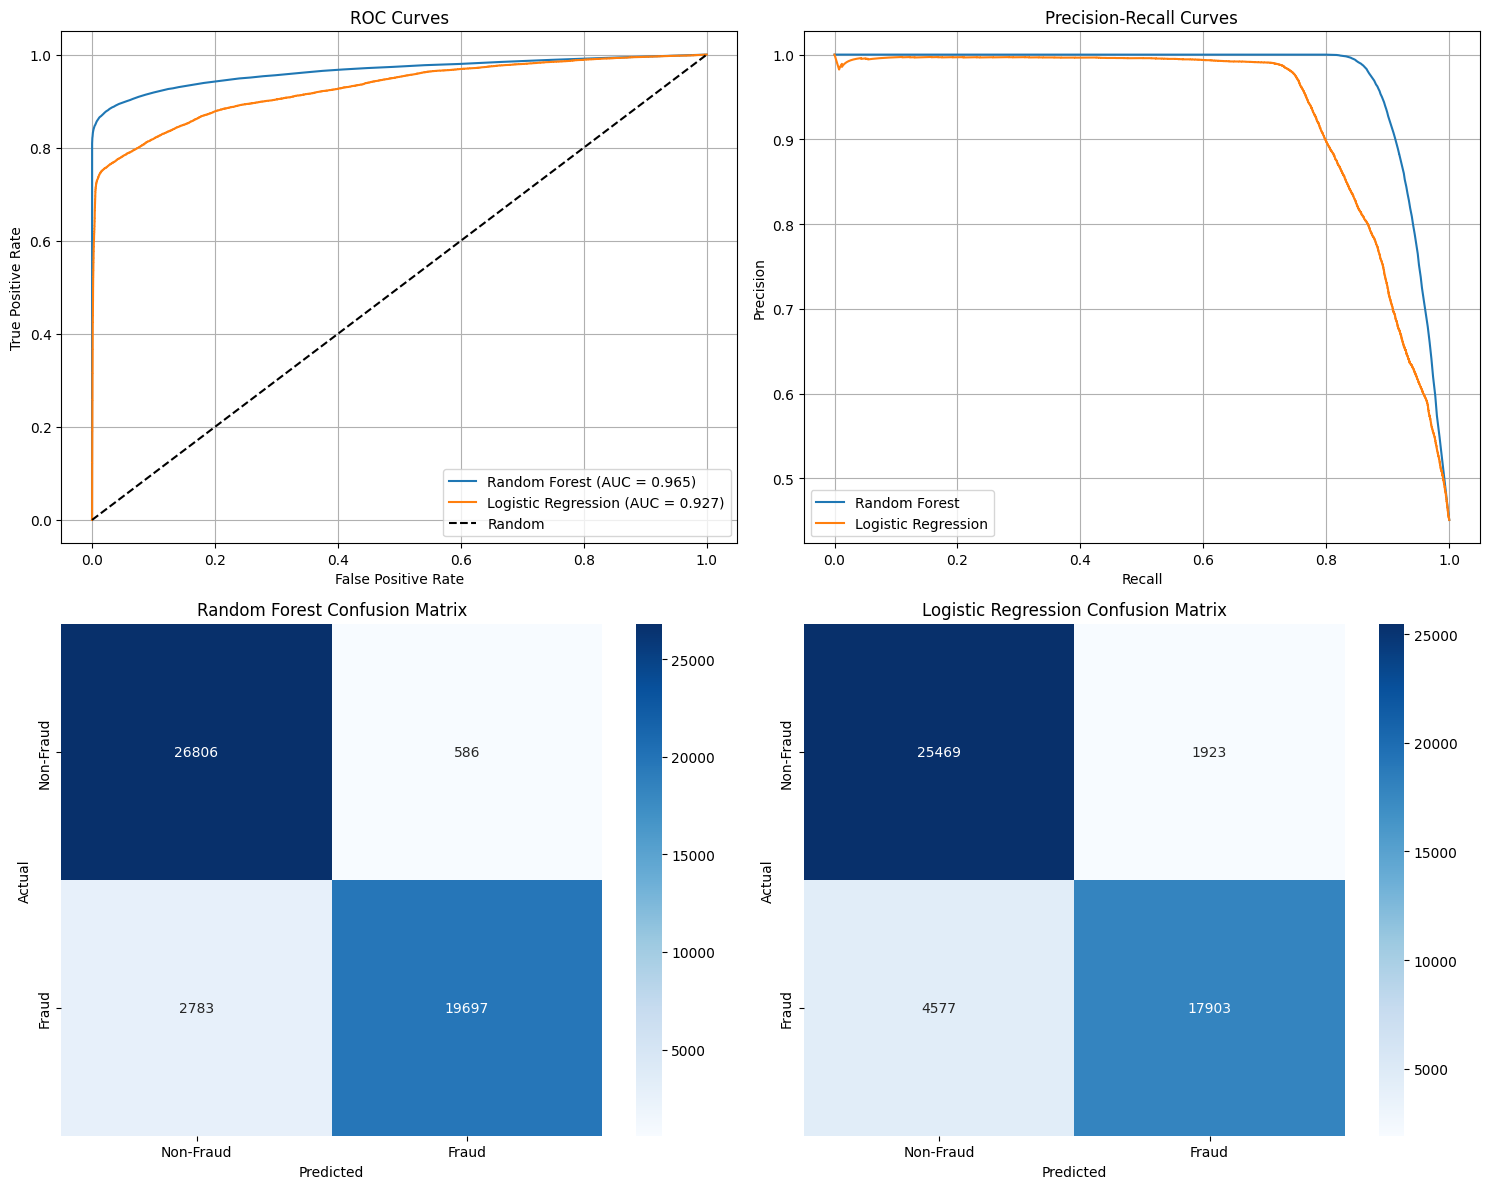

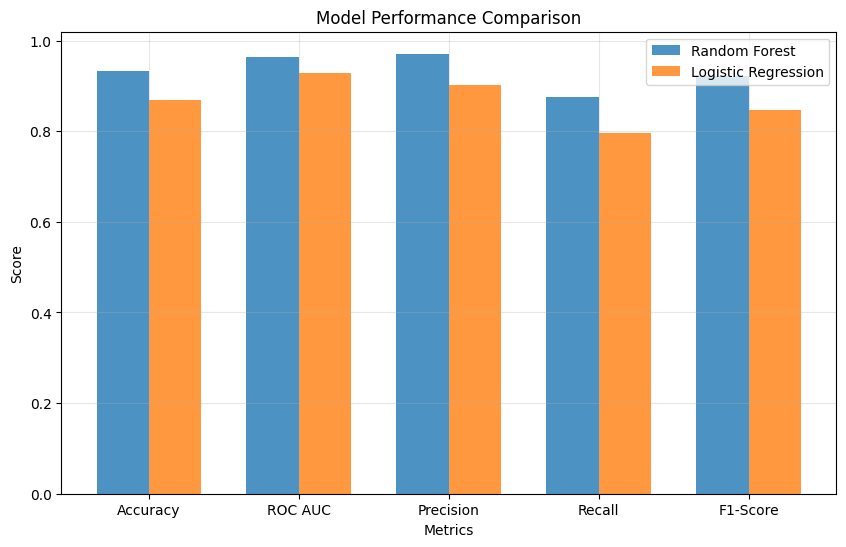

In [25]:
# VISUALIZATIONS
print("CREATING VISUALIZATIONS:")
print("="*40)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test_proper, result['probabilities'])
    auc = result['roc_auc']
    axes[0,0].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curves')
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Precision-Recall Curves
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test_proper, result['probabilities'])
    axes[0,1].plot(recall, precision, label=f'{name}')

axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curves')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Confusion Matrices
for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test_proper, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                ax=axes[1, i])
    axes[1, i].set_title(f'{name} Confusion Matrix')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. Performance comparison bar chart
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

for i, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    y_true = y_test_proper
    
    values = [
        result['accuracy'],
        result['roc_auc'],
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]
    
    plt.bar(x + i*width, values, width, label=name, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width/2, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# BUSINESS CONTEXT ANALYSIS
print("BUSINESS CONTEXT ANALYSIS:")
print("="*40)

# Define business costs (example values - adjust based on your business context)
FALSE_POSITIVE_COST = 10  # Cost of incorrectly flagging legitimate transaction
FALSE_NEGATIVE_COST = 100  # Cost of missing actual fraud

print(f"Business Costs:")
print(f"False Positive Cost: ${FALSE_POSITIVE_COST}")
print(f"False Negative Cost: ${FALSE_NEGATIVE_COST}")

# Calculate business metrics for each model
business_results = {}

for name, result in results.items():
    y_pred = result['predictions']
    y_true = y_test_proper
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business metrics
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    total_cost = (fp * FALSE_POSITIVE_COST) + (fn * FALSE_NEGATIVE_COST)
    cost_per_transaction = total_cost / len(y_true)
    
    business_results[name] = {
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'total_cost': total_cost,
        'cost_per_transaction': cost_per_transaction,
        'fp_count': fp,
        'fn_count': fn
    }
    
    print(f"\n{name}:")
    print(f"  False Positive Rate: {false_positive_rate:.4f}")
    print(f"  False Negative Rate: {false_negative_rate:.4f}")
    print(f"  Total Cost: ${total_cost:,.2f}")
    print(f"  Cost per Transaction: ${cost_per_transaction:.4f}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")

# Find best model based on business cost
best_business_model = min(business_results.keys(), 
                         key=lambda x: business_results[x]['total_cost'])

print(f"\nBest model based on business cost: {best_business_model}")
print(f"Lowest total cost: ${business_results[best_business_model]['total_cost']:,.2f}")

MODEL EXPLAINABILITY:
Creating SHAP explanations for: Random Forest


<Figure size 1200x800 with 0 Axes>

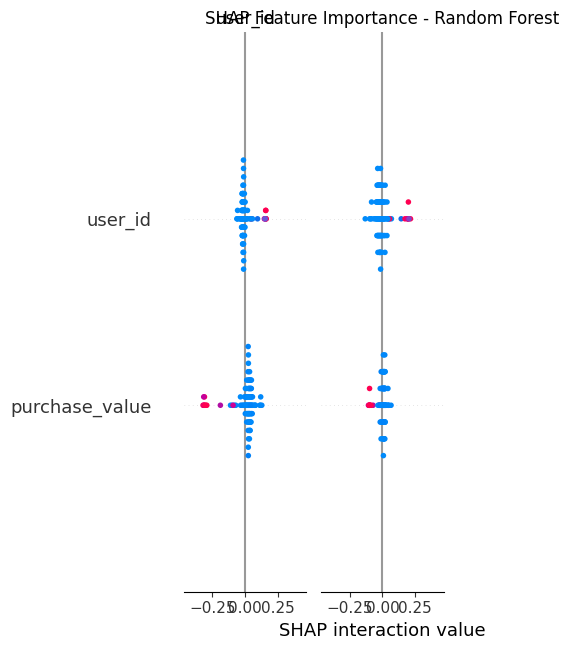

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (18, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [26]:
# MODEL EXPLAINABILITY WITH SHAP
print("MODEL EXPLAINABILITY:")
print("="*40)

import shap

# Select the best model for explainability
best_model = results[best_model_name]['model']
best_model_name_clean = best_model_name.replace(' ', '_').lower()

print(f"Creating SHAP explanations for: {best_model_name}")

# Create SHAP explainer based on model type
if hasattr(best_model, 'feature_importances_'):
    # Tree-based model (Random Forest)
    explainer = shap.TreeExplainer(best_model)
elif hasattr(best_model, 'coef_'):
    # Linear model (Logistic Regression)
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
else:
    # Other models
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[:100])

# Calculate SHAP values for a sample of test data
sample_size = min(100, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_sample = X_test_scaled.iloc[sample_indices]

shap_values = explainer.shap_values(X_sample)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()

# Plot SHAP waterfall for a specific prediction
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.waterfall_plot(shap.Explanation(values=shap_values[1][0], 
                                        base_values=explainer.expected_value[1],
                                        data=X_sample.iloc[0]), show=False)
else:
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                        base_values=explainer.expected_value,
                                        data=X_sample.iloc[0]), show=False)
plt.title(f'SHAP Waterfall Plot - {best_model_name}')
plt.tight_layout()
plt.show()

print("SHAP analysis completed!")

In [ ]:
# FINAL RECOMMENDATIONS AND MODEL SAVING
print("FINAL RECOMMENDATIONS:")
print("="*40)

# Determine final model choice based on both performance and business context
if business_results[best_model_name]['total_cost'] <= business_results[best_business_model]['total_cost'] * 1.1:
    # If best ROC model is within 10% of best business model, choose ROC model
    final_choice = best_model_name
    reason = "Best ROC AUC performance with acceptable business cost"
else:
    # Otherwise choose business-optimal model
    final_choice = best_business_model
    reason = "Lowest business cost"

print(f"Final Model Selection: {final_choice}")
print(f"Reason: {reason}")
print(f"ROC AUC: {results[final_choice]['roc_auc']:.4f}")
print(f"Business Cost: ${business_results[final_choice]['total_cost']:,.2f}")

# Save the best model
import joblib

model_filename = f'best_model_{final_choice.replace(" ", "_").lower()}.pkl'
scaler_filename = f'scaler_{final_choice.replace(" ", "_").lower()}.pkl'

joblib.dump(results[final_choice]['model'], model_filename)
joblib.dump(scaler, scaler_filename)

print(f"\nModel saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")

# Summary of key findings
print(f"\nKEY FINDINGS:")
print(f"1. Best performing model: {final_choice}")
print(f"2. ROC AUC achieved: {results[final_choice]['roc_auc']:.4f}")
print(f"3. False Positive Rate: {business_results[final_choice]['false_positive_rate']:.4f}")
print(f"4. False Negative Rate: {business_results[final_choice]['false_negative_rate']:.4f}")
print(f"5. Estimated cost per transaction: ${business_results[final_choice]['cost_per_transaction']:.4f}")

print(f"\nTask 2 completed successfully!")